# **Proyek Analisis Sentimen: Klasifikasi Ulasan Aplikasi Duolingo**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

Proyek ini bertujuan untuk membangun model Deep Learning yang dapat mengklasifikasikan sentimen dari ulasan pengguna aplikasi Duolingo menjadi tiga kelas: **Positif, Negatif, dan Netral**.

## **1. Import Library**

Mengimpor semua library yang akan digunakan dalam proyek.

In [1]:
# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

# Install
!pip install Sastrawi
!pip install tensorflow
!pip install imblearn

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Mendefinisikan kamus slang (slang_dict)
slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'gaada': 'tidak ada', 'ngga': 'tidak', 'nggak': 'tidak',
    'yg': 'yang', 'dg': 'dengan', 'dgn': 'dengan', 'dr': 'dari',
    'klo': 'kalau', 'kalo': 'kalau', 'kl': 'kalau',
    'bgt': 'banget', 'bangettt': 'banget', 'bgttt': 'banget',
    'lg': 'lagi', 'sdg': 'sedang',
    'aja': 'saja', 'sja': 'saja',
    'udah': 'sudah', 'sdh': 'sudah',
    'utk': 'untuk',
    'sm': 'sama',
    'jd': 'jadi',
    'blm': 'belum', 'blom': 'belum',
    'gw': 'saya', 'gue': 'saya',
    'gpp': 'tidak apa-apa',
    'makasih': 'terima kasih', 'mksh': 'terima kasih',
    'kak': 'kakak', 'ka': 'kakak',
    'app': 'aplikasi', 'apk': 'aplikasi',
    'donk': 'dong',
    'skrg': 'sekarang',
    'byk': 'banyak',
    'bgs': 'bagus',
    'jelek': 'jelek', 'jlk': 'jelek'
    # Bisa menambahkan lagi disini..
}

# Library untuk machine learning dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Library untuk deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

print("✅ Semua library dan resource berhasil diimport dan disiapkan.")
print(f"Versi TensorFlow: {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Semua library dan resource berhasil diimport dan disiapkan.
Versi TensorFlow: 2.18.0


## **2. Data Loading and Labeling**
Memuat dataset yang telah di-scrape dan melakukan pelabelan sentimen.

In [2]:
# Memuat dataset dari file CSV
df = pd.read_csv('dataset_duolingo.csv')

# Menampilkan 5 baris pertama
print("\nLima baris pertama dari dataset:")
print(df.head())

# Menampilkan informasi dasar (tipe data, nilai non-null)
print("\nInformasi Dataset:")
df.info()

# Memeriksa dan menghapus data duplikat jika ada
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"\nJumlah baris duplikat yang dihapus: {initial_rows - len(df)}")


Lima baris pertama dari dataset:
          userName                                            content  score  \
0  Pengguna Google                                              bagus      5   
1  Pengguna Google                                              Bagus      5   
2  Pengguna Google  alhamdulilah dengan memakai aplikasi ini saya ...      5   
3  Pengguna Google  VERY HAPPYY WITH DUOO!! fun app to learn and i...      5   
4  Pengguna Google  sangat bagus untuk orang yang ingin baru blaja...      5   

                    at  
0  2024-09-14 14:24:21  
1  2024-12-08 12:22:41  
2  2024-06-20 00:01:57  
3  2024-06-18 15:42:35  
4  2024-04-20 19:54:26  

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  13000 non-null  object
 1   content   13000 non-null  object
 2   score     13000 non-null  int64 
 3   at        13

In [3]:
# --- Melakukan Pelabelan Sentimen (Minimal 3 Kelas) ---
# membuat label sentimen berdasarkan kolom 'score'
# Score 1, 2   -> Negatif
# Score 3      -> Netral
# Score 4, 5   -> Positif

def label_sentiment(score):
    if score <= 2:
        return 'Negatif'
    elif score == 3:
        return 'Netral'
    else:
        return 'Positif'

df['sentiment'] = df['score'].apply(label_sentiment)

# Menghapus data yang tidak memiliki konten dan mereset index
df.dropna(subset=['content'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nData setelah pelabelan:")
print(df.head())
print("\nData setelah pelabelan:")
print(df[['score', 'sentiment']].head())


Data setelah pelabelan:
          userName                                            content  score  \
0  Pengguna Google                                              bagus      5   
1  Pengguna Google                                              Bagus      5   
2  Pengguna Google  alhamdulilah dengan memakai aplikasi ini saya ...      5   
3  Pengguna Google  VERY HAPPYY WITH DUOO!! fun app to learn and i...      5   
4  Pengguna Google  sangat bagus untuk orang yang ingin baru blaja...      5   

                    at sentiment  
0  2024-09-14 14:24:21   Positif  
1  2024-12-08 12:22:41   Positif  
2  2024-06-20 00:01:57   Positif  
3  2024-06-18 15:42:35   Positif  
4  2024-04-20 19:54:26   Positif  

Data setelah pelabelan:
   score sentiment
0      5   Positif
1      5   Positif
2      5   Positif
3      5   Positif
4      5   Positif


## **3. Exploratory Data Analysis (EDA)**
Menganalisis distribusi data untuk mendapatkan wawasan awal.


Distribusi Sentimen:
sentiment
Positif    12016
Negatif      668
Netral       316
Name: count, dtype: int64


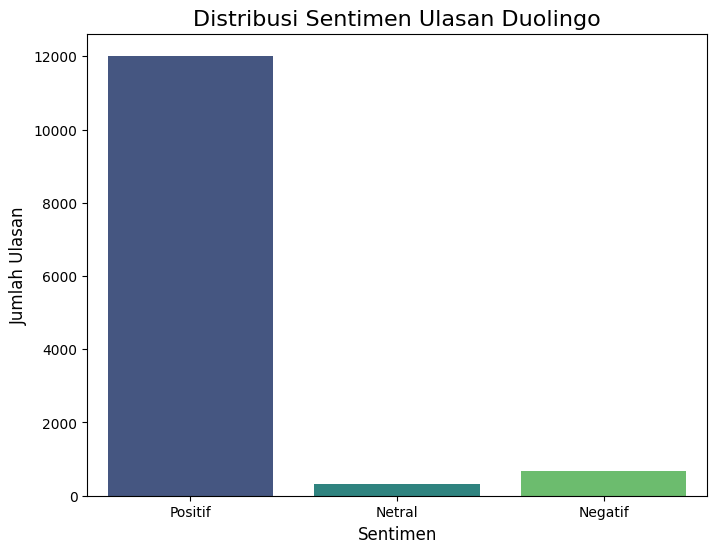

In [4]:
# Menghitung distribusi sentimen
print("\nDistribusi Sentimen:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Positif', 'Netral', 'Negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan Duolingo', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

### 3.1. Word Cloud Visualization
Melihat kata-kata yang paling sering muncul pada setiap sentimen.

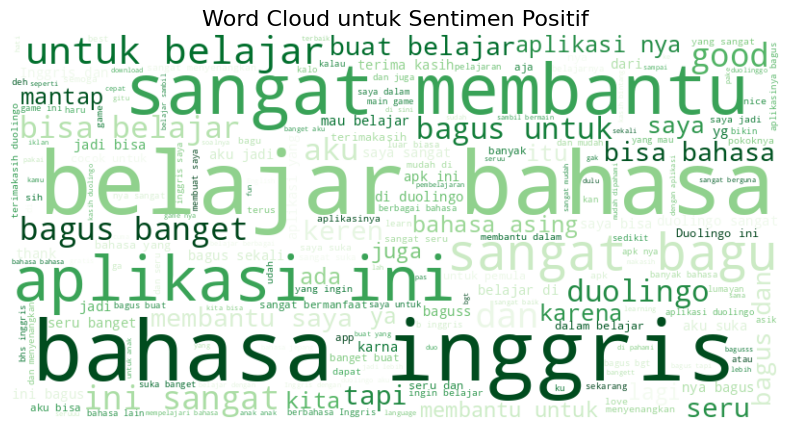

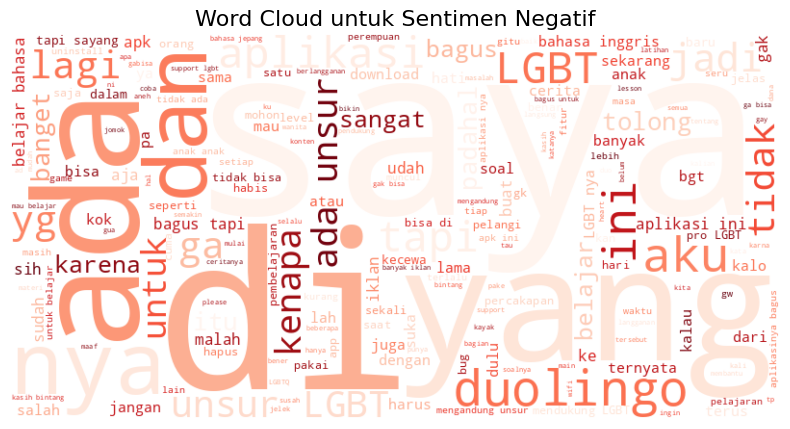

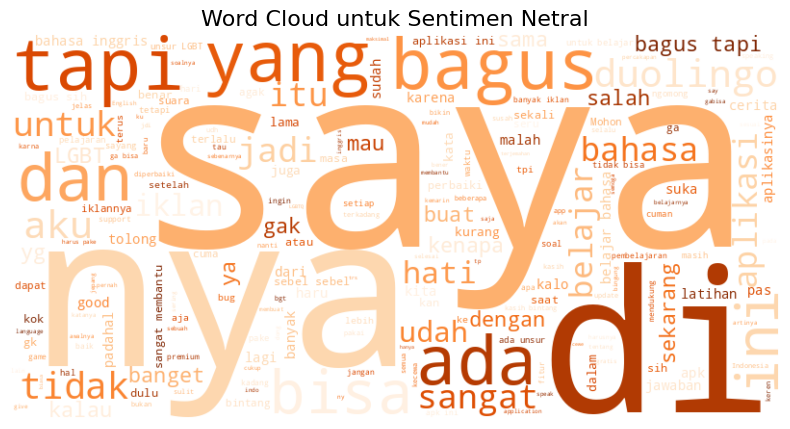

In [5]:
def generate_wordcloud(sentiment_type, color):
    # Menggabungkan semua teks untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment_type]['content'])

    # Membuat objek WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Sentimen {sentiment_type }', fontsize=16)
    plt.show()

# Membuat WordCloud untuk setiap sentimen
generate_wordcloud('Positif', 'Greens')
generate_wordcloud('Negatif', 'Reds')
generate_wordcloud('Netral', 'Oranges')

## **4. Text Preprocessing**
Membersihkan dan mempersiapkan data teks sebelum dimasukkan ke model.

In [6]:
# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar stopwords Bahasa Indonesia dan Inggris
list_stopwords = set(stopwords.words('indonesian') + stopwords.words('english'))

def preprocess_text(text):
    # Case folding: mengubah teks menjadi huruf kecil
    text = text.lower()
    # Cleaning: menghapus angka, tanda baca, link, dll.
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    # Normalisasi Slang
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]
    text = " ".join(words)
    # Tokenizing: memecah teks menjadi token/kata
    tokens = word_tokenize(text)
    # Filtering (Stopword removal): menghapus kata-kata umum
    tokens = [word for word in tokens if word not in list_stopwords]
    # Stemming: mengubah kata ke bentuk dasarnya
    tokens = [stemmer.stem(word) for word in tokens]
    # Menggabungkan kembali token menjadi kalimat
    text = ' '.join(tokens)
    return text

# Menerapkan fungsi preprocessing ke kolom 'content'
print("Memulai proses preprocessing teks...")
df['text_clean'] = df['content'].apply(preprocess_text)
print("Proses preprocessing selesai.")

# Menampilkan hasil
print("\nContoh data setelah preprocessing:")
print(df[['content', 'text_clean']].head())

Memulai proses preprocessing teks...
Proses preprocessing selesai.

Contoh data setelah preprocessing:
                                             content  \
0                                              bagus   
1                                              Bagus   
2  alhamdulilah dengan memakai aplikasi ini saya ...   
3  VERY HAPPYY WITH DUOO!! fun app to learn and i...   
4  sangat bagus untuk orang yang ingin baru blaja...   

                                          text_clean  
0                                              bagus  
1                                              bagus  
2    alhamdulilah pakai aplikasi ajar bahasa inggris  
3  happyy duoo fun aplikasi learn free prefer sup...  
4  bagus orang blajar bahasa negeri tdk bahasa in...  


## **5. Feature Extraction & Data Splitting**
Mengubah teks menjadi format numerik dan membagi data.

In [7]:
# Memetakan label sentimen ke integer
sentiment_map = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_map)

# Mendefinisikan fitur (X) dan label (y)
X = df['text_clean']
y = df['sentiment_encoded']
labels = ['Negatif', 'Netral', 'Positif'] # untuk confusion matrix

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran data latih: {len(X_train)} sampel")
print(f"Ukuran data uji: {len(X_test)} sampel")

Ukuran data latih: 10400 sampel
Ukuran data uji: 2600 sampel


In [8]:
# --- Feature Extraction untuk Deep Learning ---
# Tokenisasi dan Padding untuk model LSTM
vocab_size = 10000  # Ukuran kosakata
embedding_dim = 128
max_length = 150    # Panjang maksimal sekuens
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("✅ Fitur Tokenizer (Sequence & Padding) siap.")

# Mengubah label menjadi format one-hot encoding untuk categorical crossentropy
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

✅ Fitur Tokenizer (Sequence & Padding) siap.


In [9]:
# --- Feature Extraction untuk Machine Learning Klasik ---
# Menggunakan TF-IDF
tfidf_vectorizer_optimized = TfidfVectorizer(
    ngram_range=(1, 2),  # Mempertimbangkan kata tunggal (unigram) dan frasa 2 kata (bigram)
    max_df=0.9,          # Mengabaikan kata yang muncul di > 90% dokumen (terlalu umum)
    min_df=5,            # Mengabaikan kata yang muncul di < 5 dokumen (terlalu langka/mungkin typo)
    max_features=5000    # Membatasi jumlah fitur untuk mencegah noise dan mempercepat training
)

# Latih vectorizer HANYA pada data latih (X_train)
X_train_tfidf = tfidf_vectorizer_optimized.fit_transform(X_train)

# Gunakan vectorizer yang sama untuk mentransformasi data uji (tanpa fit ulang)
X_test_tfidf = tfidf_vectorizer_optimized.transform(X_test)

print("✅ Fitur TF-IDF siap.")
print(f"Bentuk matriks TF-IDF data latih: {X_train_tfidf.shape}")
print(f"Bentuk matriks TF-IDF data uji: {X_test_tfidf.shape}")

✅ Fitur TF-IDF siap.
Bentuk matriks TF-IDF data latih: (10400, 1790)
Bentuk matriks TF-IDF data uji: (2600, 1790)


## **6. Penanganan Imbalanced Dataset**
Menerapkan SMOTE hanya pada data latih TF-IDF.

Menangani Imbalanced Dataset dengan SMOTE...

Distribusi kelas pada data latih SEBELUM SMOTE:
sentiment_encoded
2    9613
0     534
1     253
Name: count, dtype: int64

Distribusi kelas pada data latih SETELAH SMOTE:
sentiment_encoded
2    9613
0    9613
1    9613
Name: count, dtype: int64


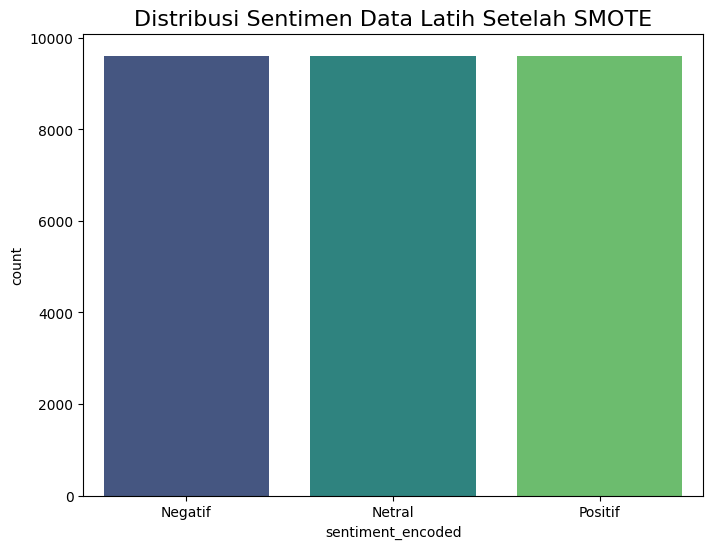

In [10]:
print("Menangani Imbalanced Dataset dengan SMOTE...")
print("\nDistribusi kelas pada data latih SEBELUM SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)

# Terapkan SMOTE HANYA pada data latih TF-IDF
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("\nDistribusi kelas pada data latih SETELAH SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Visualisasi untuk membuktikan keseimbangan data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote, palette='viridis')
plt.title('Distribusi Sentimen Data Latih Setelah SMOTE', fontsize=16)
plt.xticks(ticks=[0, 1, 2], labels=labels)
plt.show()

## **7. Model Training and Evaluation (3 Skenario Percobaan)**
Melatih dan mengevaluasi tiga model berbeda untuk perbandingan.

In [11]:
# Inisialisasi dictionary untuk menyimpan hasil
training_scheme_results = {}

# --- Fungsi untuk Visualisasi Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name): # agar bisa digunakan berulang kali untuk setiap model
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

### 7.1. Eksperimen 1: Deep Learning - LSTM


--- Memulai Eksperimen 1: Stacked LSTM ---
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5253 - loss: 1.0917
Epoch 1: val_accuracy improved from -inf to 0.92423, saving model to best_lstm_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 464ms/step - accuracy: 0.5249 - loss: 1.0918 - val_accuracy: 0.9242 - val_loss: 1.0423
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.3091 - loss: 1.1102
Epoch 2: val_accuracy did not improve from 0.92423
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 432ms/step - accuracy: 0.3093 - loss: 1.1102 - val_accuracy: 0.9242 - val_loss: 1.0445
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5839 - loss: 1.0670
Epoch 3: val_accuracy did not improve from 0.92423
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 451ms/step - accuracy: 0.5827 - loss: 1.0672 - val_accuracy: 0.0242 - val_loss: 1.1299
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.1682 - loss: 1.1294
Epoch 4: val_accuracy did not improve from 0.92423
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 454ms/step - accuracy: 0.1685 - loss: 1.1292 - val_accuracy: 0.9242 - val_loss: 1.0746
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3862 - loss: 1.1122
Epoch 5: val_accura

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step

Laporan Klasifikasi - Stacked LSTM:
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       134
      Netral       0.00      0.00      0.00        63
     Positif       0.92      1.00      0.96      2403

    accuracy                           0.92      2600
   macro avg       0.31      0.33      0.32      2600
weighted avg       0.85      0.92      0.89      2600



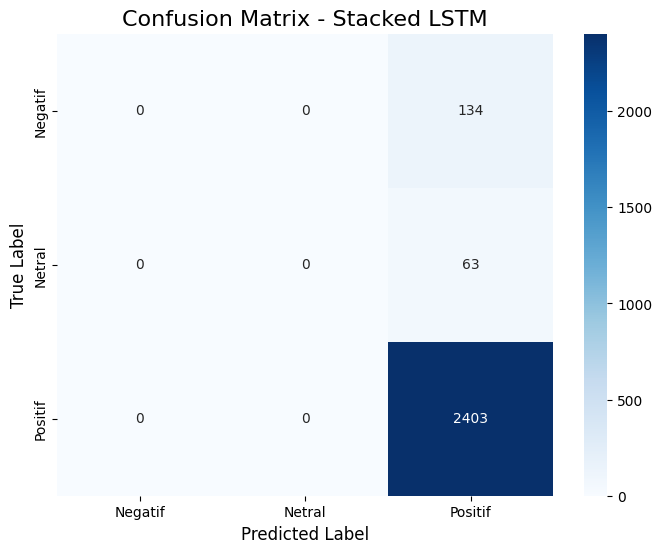

In [12]:
# --- Eksperimen 1: Deep Learning - Stacked LSTM ---
# Target akurasi > 92%
# Tokenisasi dan Padding untuk model LSTM (dilakukan pada data asli sebelum SMOTE)
vocab_size = 10000; embedding_dim = 128; max_length = 150; trunc_type = 'post'; padding_type = 'post'; oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print("\n--- Memulai Eksperimen 1: Stacked LSTM ---")
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# LSTM lebih baik ditangani dengan class_weight
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history_lstm = model_lstm.fit(X_train_pad, y_train_cat, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_cat), callbacks=[model_checkpoint], class_weight=class_weights_dict, verbose=1)

# Evaluasi menggunakan model terbaik
best_model_lstm = load_model('best_lstm_model.h5')
y_pred_lstm = np.argmax(best_model_lstm.predict(X_test_pad), axis=1)
train_acc_lstm = accuracy_score(y_train, np.argmax(best_model_lstm.predict(X_train_pad), axis=1))
test_acc_lstm = accuracy_score(y_test, y_pred_lstm)
training_scheme_results['Skema 1: Stacked LSTM (Class Weight)'] = {'train_acc': train_acc_lstm, 'test_acc': test_acc_lstm}

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - Stacked LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lstm, "Stacked LSTM")

### 7.2. Eksperimen 2: Machine Learning - SVM


--- Memulai Eksperimen 2 (Perbaikan): LinearSVC ---
Melatih LinearSVC pada data hasil SMOTE...

Akurasi Training LinearSVC: 90.40%
Akurasi Testing LinearSVC: 80.54%

Laporan Klasifikasi - LinearSVC:
              precision    recall  f1-score   support

     Negatif       0.28      0.71      0.40       134
      Netral       0.09      0.32      0.14        63
     Positif       0.97      0.82      0.89      2403

    accuracy                           0.81      2600
   macro avg       0.45      0.62      0.48      2600
weighted avg       0.92      0.81      0.85      2600



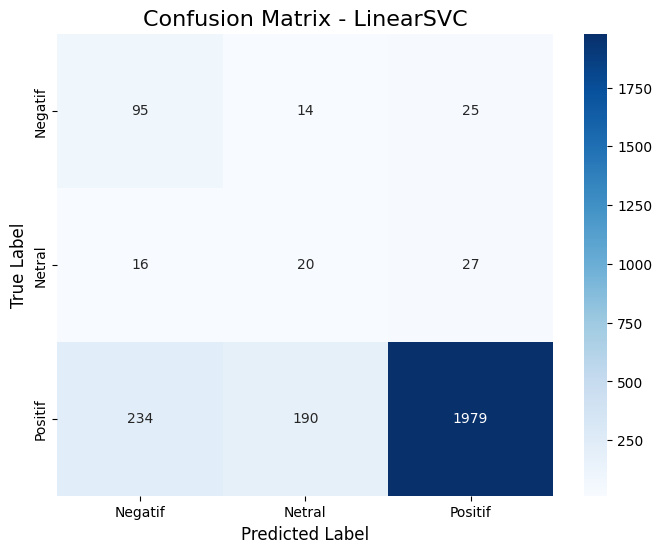

In [13]:
print("\n--- Memulai Eksperimen 2 (Perbaikan): LinearSVC ---")

# 1. Definisikan model LinearSVC. Model ini dioptimalkan untuk data linear
# menggunakan class_weight='balanced' untuk menangani data uji yang tidak seimbang.
model_svm_linear = LinearSVC(random_state=42, class_weight='balanced', max_iter=2000)

# 2. Latih model pada data latih yang sudah di-SMOTE
# memberikan model data yang seimbang untuk dipelajari.
print("Melatih LinearSVC pada data hasil SMOTE...")
model_svm_linear.fit(X_train_smote, y_train_smote)

# --- Evaluasi Model LinearSVC ---
# Prediksi pada data latih (SMOTE) dan data uji (asli, non-SMOTE)
y_pred_train_svm = model_svm_linear.predict(X_train_smote)
y_pred_test_svm = model_svm_linear.predict(X_test_tfidf) # Evaluasi tetap pada data uji asli

# Hitung akurasi
train_acc_svm = accuracy_score(y_train_smote, y_pred_train_svm)
test_acc_svm = accuracy_score(y_test, y_pred_test_svm)
training_scheme_results['Skema 2: LinearSVC'] = {'train_acc': train_acc_svm, 'test_acc': test_acc_svm}

# Laporan Klasifikasi
print(f"\nAkurasi Training LinearSVC: {train_acc_svm*100:.2f}%")
print(f"Akurasi Testing LinearSVC: {test_acc_svm*100:.2f}%")
print("\nLaporan Klasifikasi - LinearSVC:")
print(classification_report(y_test, y_pred_test_svm, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test_svm, "LinearSVC")

### 7.3. Eksperimen 3: Machine Learning - Logistic Regression


--- Memulai Eksperimen 3: Logistic Regression dengan Class Weight dan Tuning Ekstensif ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Parameter terbaik untuk Logistic Regression: {'C': 1, 'solver': 'liblinear'}

Akurasi Training LR: 95.73%
Akurasi Testing LR: 93.19%

Laporan Klasifikasi - Logistic Regression:
              precision    recall  f1-score   support

     Negatif       0.62      0.56      0.59       134
      Netral       0.16      0.13      0.14        63
     Positif       0.96      0.97      0.97      2403

    accuracy                           0.93      2600
   macro avg       0.58      0.55      0.57      2600
weighted avg       0.93      0.93      0.93      2600



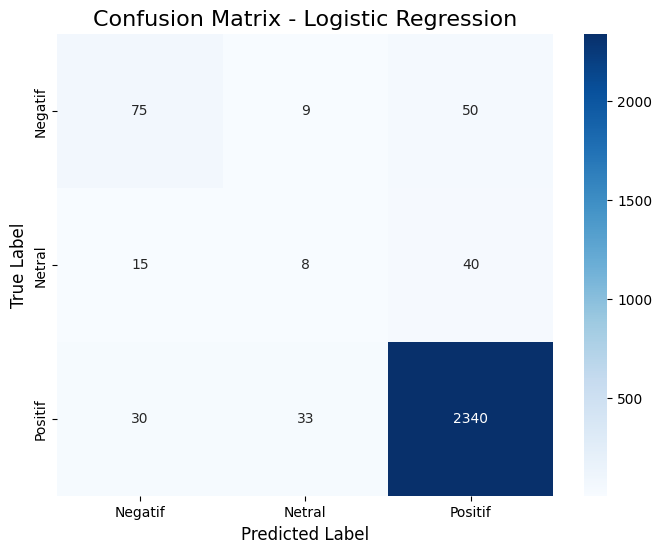

In [14]:
print("\n--- Memulai Eksperimen 3: Logistic Regression dengan Class Weight dan Tuning Ekstensif ---")

# 1. Definisikan model dengan class_weight='balanced'
model_lr = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced')

# 2. Perluas hyperparameter
param_grid_lr = {
    'C': [1, 10, 50, 100],
    'solver': ['liblinear', 'saga']
}

# 3. Siapkan GridSearchCV
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')

# 4. Latih model pada data latih asli
grid_search_lr.fit(X_train_tfidf, y_train)

# 5. Dapatkan model terbaik
best_model_lr = grid_search_lr.best_estimator_
print("\nParameter terbaik untuk Logistic Regression:", grid_search_lr.best_params_)

# --- Evaluasi Model Logistic Regression Terbaik ---
y_pred_train_lr = best_model_lr.predict(X_train_tfidf)
y_pred_test_lr = best_model_lr.predict(X_test_tfidf)

train_acc_lr = accuracy_score(y_train, y_pred_train_lr)
test_acc_lr = accuracy_score(y_test, y_pred_test_lr)
training_scheme_results['Skema 3: Logistic Regression'] = {'train_acc': train_acc_lr, 'test_acc': test_acc_lr}

print(f"\nAkurasi Training LR: {train_acc_lr*100:.2f}%")
print(f"Akurasi Testing LR: {test_acc_lr*100:.2f}%")
print("\nLaporan Klasifikasi - Logistic Regression:")
print(classification_report(y_test, y_pred_test_lr, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test_lr, "Logistic Regression")

## **8. Perbandingan Model dan Kesimpulan**
Meringkas hasil dari ketiga eksperimen untuk menentukan model terbaik.

In [15]:
print("\n--- PERBANDINGAN HASIL SKEMA PELATIHAN ---")
if training_scheme_results:
    # Membuat DataFrame dari dictionary hasil
    results_df = pd.DataFrame.from_dict(training_scheme_results, orient='index')
    results_df = results_df.sort_values(by='test_acc', ascending=False)

    # Memformat akurasi menjadi persentase
    results_df['train_acc'] = results_df['train_acc'].apply(lambda x: f"{x*100:.2f}%")
    results_df['test_acc'] = results_df['test_acc'].apply(lambda x: f"{x*100:.2f}%")

    print(results_df)

    # Cek pemenuhan kriteria submission secara otomatis
    num_schemes_above_85_test = sum(1 for res in training_scheme_results.values() if res['test_acc'] >= 0.85)
    one_scheme_above_92_train_test = any(1 for res in training_scheme_results.values() if res['train_acc'] > 0.92 and res['test_acc'] > 0.92)

    print(f"\nJumlah skema dengan akurasi test >= 85%: {num_schemes_above_85_test}")
    print(f"Ada skema dengan akurasi train & test > 92%: {one_scheme_above_92_train_test}")

    print("\n--- Status Pemenuhan Kriteria ---")
    if num_schemes_above_85_test >= 3:
        print("✅ Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.")
        if one_scheme_above_92_train_test:
            print("✅ Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.")
            print("\n===> SELURUH KRITERI AKURASI UNTUK BINTANG 5 TELAH TERPENUHI <===")
        else:
            print("❌ Saran 2 (Akurasi >92%) TIDAK terpenuhi. Perlu optimasi lebih lanjut pada model utama.")
    else:
        print("❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.")
        print("Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.")

else:
    print("Tidak ada hasil skema pelatihan untuk dibandingkan.")


--- PERBANDINGAN HASIL SKEMA PELATIHAN ---
                                     train_acc test_acc
Skema 3: Logistic Regression            95.73%   93.19%
Skema 1: Stacked LSTM (Class Weight)    92.43%   92.42%
Skema 2: LinearSVC                      90.40%   80.54%

Jumlah skema dengan akurasi test >= 85%: 2
Ada skema dengan akurasi train & test > 92%: True

--- Status Pemenuhan Kriteria ---
❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.
Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.


## **9. Inference (Uji Coba Model dengan Kalimat Baru)**
Menguji model LSTM terbaik dengan beberapa contoh kalimat baru

In [16]:
def predict_single_sentence(sentence, model, tokenizer):
    """
    Fungsi untuk memprediksi sentimen dari satu kalimat baru.
    - sentence: Kalimat mentah (string).
    - model: Model Keras yang sudah dilatih.
    - tokenizer: Tokenizer Keras yang sudah di-fit pada data training.
    """
    print(f"===== Menganalisis Kalimat: '{sentence}' =====")

    # 1. Preprocessing teks
    processed_text = preprocess_text(sentence)
    print(f"1. Teks Setelah Preprocessing: '{processed_text}'")

    # 2. Tokenisasi dan Padding menggunakan tokenizer
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # 3. Lakukan prediksi
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = labels[predicted_class_index]

    # 4. Tampilkan probabilitas dan hasil
    print("\n2. Probabilitas Prediksi:")
    for i, label in enumerate(labels):
        print(f"- {label:<7} : {prediction[0][i]*100:.2f}%")

    print(f"\n--> Hasil Akhir: **{predicted_class_label}**")
    print("=============================================\n")


# --- Memuat model terbaik dan tokenizer yang sesuai ---
try:
    best_model = load_model('best_lstm_model.h5')
    print("✅ Model LSTM terbaik ('best_lstm_model.h5') berhasil dimuat.")

    # Daftar kalimat untuk diuji
    test_sentences = [
        "Aplikasi ini sangat membantu saya belajar bahasa baru! Luar biasa!",
        "Update terbaru banyak bug dan sering crash.",
        "Biasa aja sih, fiturnya standar.",
        "Kenapa sekarang harus bayar? Dulu gratis padahal. Kecewa.",
        "Good app, but needs more languages.",
        "Not bad."
    ]

    print("\n\n--- MEMULAI UJI COBA INFERENCE PADA KALIMAT BARU ---")
    for sentence in test_sentences:
        # Panggil fungsi dengan model dan tokenizer yang benar
        predict_single_sentence(sentence, best_model, tokenizer)

except Exception as e:
    print(f"❌ Gagal memuat model atau menjalankan inference: {e}")
    print("Pastikan sel pelatihan model LSTM telah dijalankan dan file 'best_lstm_model.h5' telah tersimpan.")

✅ Model LSTM terbaik ('best_lstm_model.h5') berhasil dimuat.


--- MEMULAI UJI COBA INFERENCE PADA KALIMAT BARU ---
===== Menganalisis Kalimat: 'Aplikasi ini sangat membantu saya belajar bahasa baru! Luar biasa!' =====
1. Teks Setelah Preprocessing: 'aplikasi bantu ajar bahasa'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step

2. Probabilitas Prediksi:
- Negatif : 32.36%
- Netral  : 32.12%
- Positif : 35.52%

--> Hasil Akhir: **Positif**

===== Menganalisis Kalimat: 'Update terbaru banyak bug dan sering crash.' =====
1. Teks Setelah Preprocessing: 'update baru bug crash'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

2. Probabilitas Prediksi:
- Negatif : 32.36%
- Netral  : 32.12%
- Positif : 35.52%

--> Hasil Akhir: **Positif**

===== Menganalisis Kalimat: 'Biasa aja sih, fiturnya standar.' =====
1. Teks Setelah Preprocessing: 'sih fiturnya standar'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

2. Probabilitas Prediksi:
- Negatif : 32.36%
- Netral  : 32.12%
- Positif : 35.52%

--> Hasil Akhir: **Positif**

===